In [12]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import trame

In [32]:
# Enable notebook rendering
pv.set_jupyter_backend('static')

### 1. Select Points for the spline

In [83]:
# # Create a circle in the x-z plane
# def create_circle(radius, n_points=100):
#     theta = np.linspace(0, 2 * np.pi, n_points)
#     x = radius * np.cos(theta)
#     z = radius * np.sin(theta)
#     points = np.vstack((x, np.zeros(n_points), z)).T
#     lines = np.column_stack((np.full(n_points, 2), np.arange(n_points), np.roll(np.arange(n_points), -1)))
#     lines = lines.flatten()
#     circle = pv.PolyData(points)
#     circle.lines = lines
#     return circle

# # Extrude the circles in the y direction to create cylinders
# def extrude_circle(circle, extrusion_length_pos, extrusion_length_neg):
#     extruded_pos = circle.extrude([0, extrusion_length_pos, 0])
#     extruded_neg = circle.extrude([0, extrusion_length_neg, 0])
#     extruded = extruded_pos + extruded_neg
#     return extruded



In [109]:
# Load the intraoral mesh
intraoral_mesh = pv.read(r'D:\sunny\Codes\DPS\data\Origin\000101_origin.ply')

# Calculate theta values for each vertex
x, z = intraoral_mesh.points[:, 0], intraoral_mesh.points[:, 2]
theta = np.arctan2(z, x)

# Define the theta values to sample (every π/16 radians)
theta_values = np.linspace(-np.pi, np.pi, 32, endpoint=False)

# Select the points with max and min distances for each theta value
outer_points = []
inner_points = []
for t in theta_values:
    mask = np.abs(theta - t) < np.pi / 32
    selected_points = intraoral_mesh.points[mask]
    if selected_points.size > 0:
        distances = np.linalg.norm(selected_points[:, [0, 2]], axis=1)
        outer_point = selected_points[np.argmax(distances)]
        inner_point = selected_points[np.argmin(distances)]
        outer_point[1] = 0.0  # Project onto x-z plane
        inner_point[1] = 0.0  # Project onto x-z plane
        outer_points.append(outer_point)
        inner_points.append(inner_point)

outer_points = np.array(outer_points)
inner_points = np.array(inner_points)

# Close the loops
outer_points = np.vstack([outer_points, outer_points[0]])
inner_points = np.vstack([inner_points, inner_points[0]])


print(f'Outer Points: {outer_points.shape}')
print(f'Inner Points: {inner_points.shape}')

Outer Points: (26, 3)
Inner Points: (26, 3)


### 2. Create the Splines and Extrude to Curved Planes

In [115]:
# Function to create a spline from points
def create_spline(points, n_points=100):
    spline = pv.Spline(points, n_points=n_points)
    t_values = np.linspace(0, 1, n_points)
    return spline, t_values

# Create splines for outer and inner points
outer_spline, t_values_outer = create_spline(outer_points)
inner_spline, t_values_inner = create_spline(inner_points)

# Extrude the splines to create curved planes
def extrude_spline(spline, extrusion_length_pos, extrusion_length_neg):
    extruded_pos = spline.extrude([0, extrusion_length_pos, 0])
    extruded_neg = spline.extrude([0, extrusion_length_neg, 0])
    extruded = extruded_pos + extruded_neg
    return extruded

# Calculate the extrusion length
y_min = np.min(intraoral_mesh.points[:, 1])
y_max = np.max(intraoral_mesh.points[:, 1])
extrusion_length_pos = y_max
extrusion_length_neg = y_min
print(f'Extrusion length: {extrusion_length_pos} (pos), {extrusion_length_neg} (neg)')

# Create curved planes
curved_plane_outer = extrude_spline(outer_spline, extrusion_length_pos, extrusion_length_neg)
curved_plane_inner = extrude_spline(inner_spline, extrusion_length_pos, extrusion_length_neg)

Extrusion length: -0.1180529072880745 (pos), -21.39175796508789 (neg)


d:\Users\sunny\anaconda3\envs\env_dps\lib\site-packages\pyvista\core\filters\poly_data.py:2997: PyVistaFutureWarning: The default value of the ``capping`` keyword argument will change in a future version to ``True`` to match the behavior of VTK. We recommend passing the keyword explicitly to prevent future surprises.
  warnings.warn(


In [107]:
# # Load the intraoral mesh
# intraoral_mesh = pv.read(r'D:\sunny\Codes\DPS\data\Origin\000101_origin.ply')

# # Calculate the radii: 
# # the outer radius is the maximum distance from the origin
# # the inner radius is the minimum distance
# distances = np.linalg.norm(intraoral_mesh.points[:, [0, 2]], axis=1)
# outer_radius = np.max(distances)
# inner_radius = np.min(distances)
# n_points = 100

# # Calculate the extrusion length
# y_min = np.min(intraoral_mesh.points[:, 1])
# y_max = np.max(intraoral_mesh.points[:, 1])
# extrusion_length_pos = y_max
# extrusion_length_neg = y_min
# print(f'Extrusion length: {extrusion_length_pos} (pos), {extrusion_length_neg} (neg)')

# # Create the circles
# circle_outer = create_circle(outer_radius, n_points)
# circle_inner = create_circle(inner_radius, n_points)
# # Extrude the circles to create cylinders
# cylinder_outer = extrude_circle(circle_outer, extrusion_length_pos, extrusion_length_neg)
# cylinder_inner = extrude_circle(circle_inner, extrusion_length_pos, extrusion_length_neg)


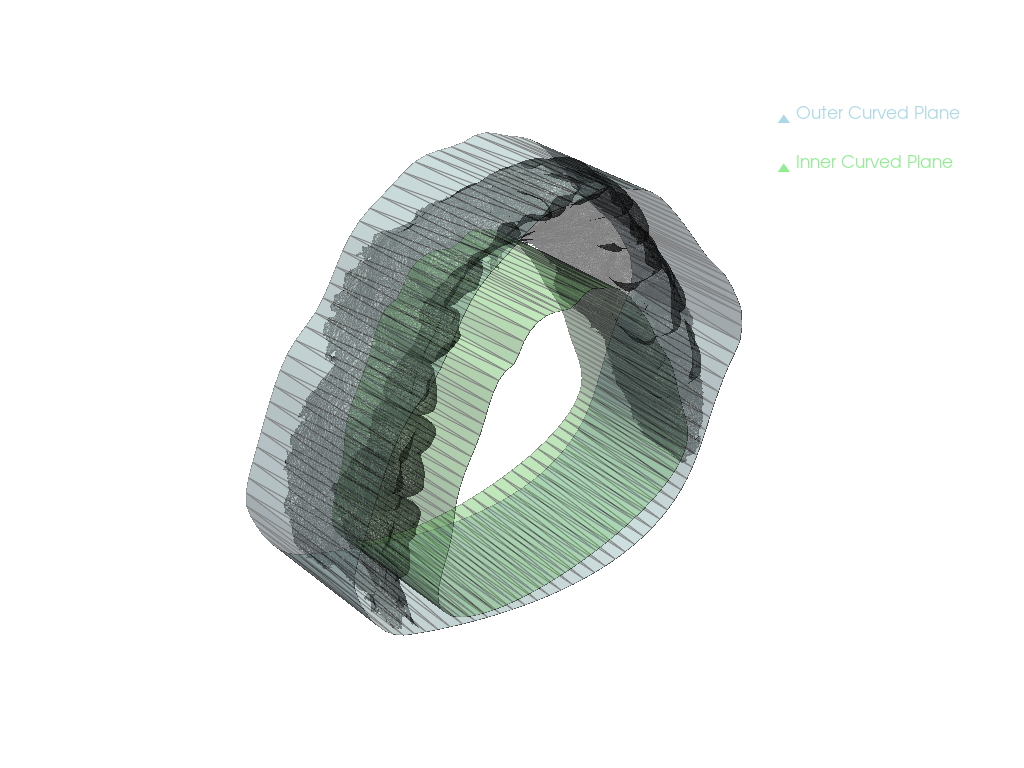

In [116]:
# Visualize the splines and curved planes
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(intraoral_mesh, color='white', opacity=0.5, show_edges=True, label='Original Mesh')
plotter.add_mesh(curved_plane_outer, color='lightblue', opacity=0.5, show_edges=True, label='Outer Curved Plane')
plotter.add_mesh(curved_plane_inner, color='lightgreen', opacity=0.5, show_edges=True, label='Inner Curved Plane')
plotter.add_legend()
plotter.show()

### 2. Define the Projection Function with Color Information

In [92]:
# # Function to project a mesh onto a cylinder and embed color information
# def project_mesh_onto_cylinder(mesh, radius, y_min, y_max, is_inner=False):
#     projected_uv = []
#     colors = []
#     extrusion_length = y_max - y_min
#     for point, color in zip(mesh.points, mesh.point_data['RGB']):
#         x, y, z = point
#         theta = np.arctan2(z, x)
#         r = np.sqrt(x**2 + z**2)
#         if is_inner:
#             if r>=radius: # For inner cylinder, we project if the point is outside the radius
#                 uv = [theta / (2 * np.pi), (y - y_min) / extrusion_length]
#                 projected_uv.append(uv)
#                 colors.append(color / 255.0)
#         else: 
#             if r <= radius: # For outer cylinder, we project if the point is inside the radius 
#                 uv = [theta / (2 * np.pi), (y - y_min) / extrusion_length]
#                 projected_uv.append(uv)
#                 colors.append(color / 255.0)  # Normalize color to [0, 1]
#     projected_uv = np.array(projected_uv)
#     colors = np.array(colors)
#     print(f'Projected UV: {projected_uv.shape}')
#     print(f'Colors: {colors.shape}')
#     return projected_uv, colors

In [117]:
def project_mesh_onto_curve(mesh, curve, t_values, extrusion_length):
    projected_uv = []
    colors = []
    for point, color in zip(mesh.points, mesh.point_data['RGB']):
        x, y, z = point
        r = np.sqrt(x**2 + z**2)
        distances = np.linalg.norm(curve.points[:, [0, 2]] - [x, z], axis=1)
        closest_point_idx = np.argmin(distances)
        t = t_values[closest_point_idx]
        uv = [t, (y - y_min) / extrusion_length]
        projected_uv.append(uv)
        colors.append(color / 255.0)  # Normalize color to [0, 1]
    projected_uv = np.array(projected_uv)
    colors = np.array(colors)
    print(f'Projected UV: {projected_uv.shape}')
    print(f'Colors: {colors.shape}')
    return projected_uv, colors

### 3. Load the Intraoral Mesh and Apply Projections

Projected UV: (33603, 2)
Colors: (33603, 3)
Projected UV: (33603, 2)
Colors: (33603, 3)


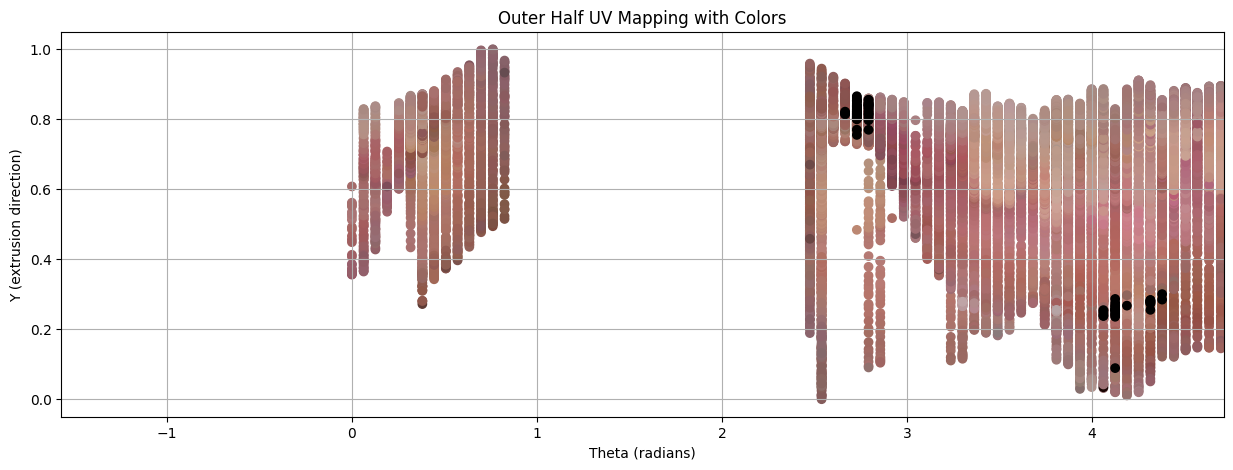

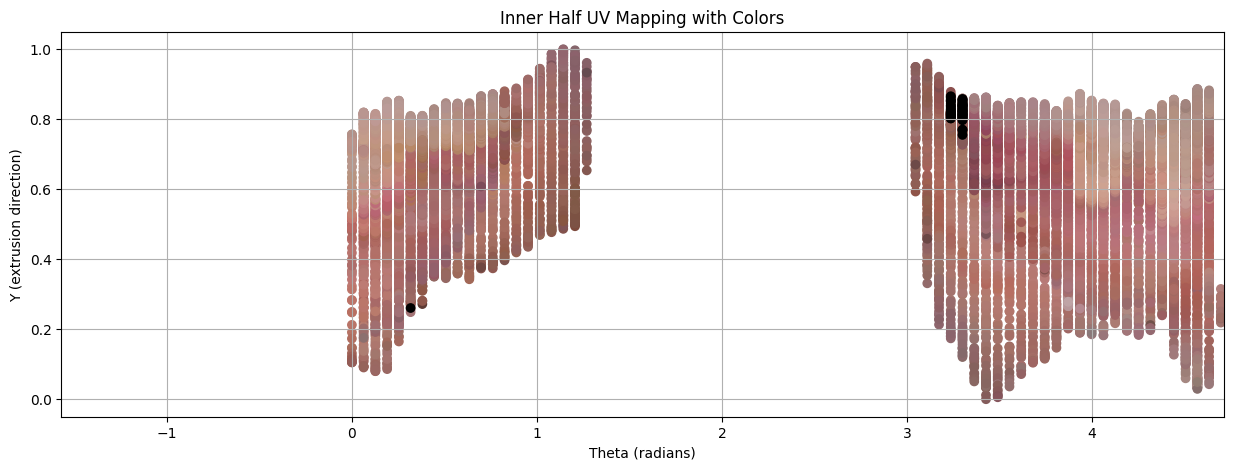

In [118]:
# Visualize the projections with color information
def visualize_uv_mapping_with_colors(mesh, uv_coords, colors, title):
    if uv_coords.size == 0:
        print(f'No UV coordinates to plot for {title}')
        return
    plt.figure(figsize=(15, 5))
    plt.scatter(uv_coords[:, 0]*(2*np.pi), uv_coords[:, 1], c=colors, marker='o')
    plt.title(title)
    plt.xlabel('Theta (radians)')
    plt.ylabel('Y (extrusion direction)')
    plt.xlim(-np.pi / 2, 3 * np.pi / 2)  # Set x-axis limits to the new range
    plt.grid(True)
    plt.show()


# Project the mesh onto the curved planes
projected_outer_uv, colors_outer = project_mesh_onto_curve(intraoral_mesh, outer_spline, t_values_outer, extrusion_length_pos - extrusion_length_neg)
projected_inner_uv, colors_inner = project_mesh_onto_curve(intraoral_mesh, inner_spline, t_values_inner, extrusion_length_pos - extrusion_length_neg)

# Visualize the projections with color information
visualize_uv_mapping_with_colors(intraoral_mesh, projected_outer_uv, colors_outer, 'Outer Half UV Mapping with Colors')
visualize_uv_mapping_with_colors(intraoral_mesh, projected_inner_uv, colors_inner, 'Inner Half UV Mapping with Colors')
